In [1]:
import tensorflow
import torch
import os
import pandas as pd
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
import torch.nn as nn
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

csv_file_path = '../../data/clocks.csv'
clocks_csv = pd.read_csv(csv_file_path)

classes_number = clocks_csv['class index'].unique()

class_index_to_label_map = dict(zip(clocks_csv['class index'], clocks_csv['labels']))
classes_number.__len__()

144

In [3]:
def create_dataframes(dataset_type, transforms):
    dataset = []
    df = clocks_csv[clocks_csv['data set'] == dataset_type]
    for index, row in df.iterrows():
        with Image.open(os.path.join('../../data/', row['filepaths'])) as img:
            img_transform = transforms(img)
            label = row['class index']
            dataset.append([img_transform, label])
    return dataset

In [4]:
# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

val_and_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = create_dataframes('train', val_and_test_transform)
valid_data = create_dataframes('valid', val_and_test_transform)
test_data = create_dataframes('test', val_and_test_transform)
random.shuffle(train_data)
train_dataset = pd.DataFrame(train_data)
valid_dataset = pd.DataFrame(valid_data)
test_dataset = pd.DataFrame(test_data)

In [5]:
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 144
lr = 1e-04

subtract_pixel_mean = True
n = 3

depth = n * 9 + 2

model_type = f'ResNet {depth}'

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True)

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


             6_00              7_55             11_30             10_45              2_55              2_15              4_45              8_30


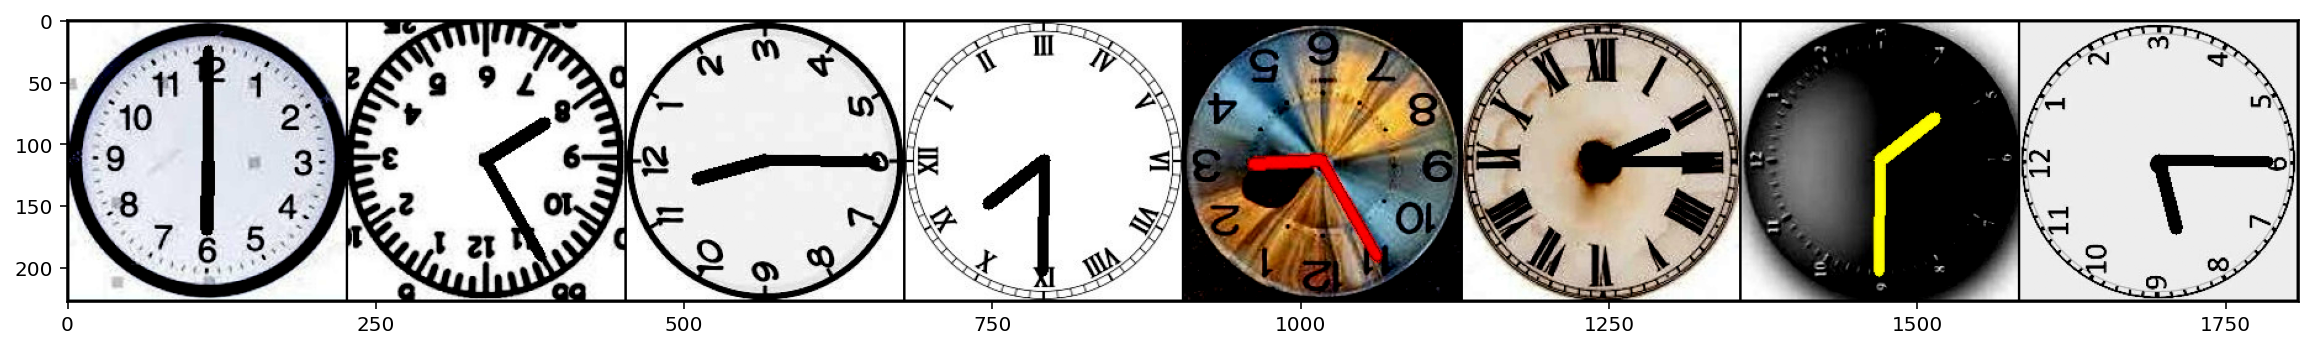

In [9]:
images, labels = list(train_dataset[0].to_numpy()), train_dataset[1].to_numpy()
plt.figure(figsize=(20,10)) 

imshow(torchvision.utils.make_grid(images[:8]))

print(' '.join('%17s' % class_index_to_label_map[list(class_index_to_label_map.keys())[labels[j]]] for j in range(8)))

In [11]:
def split_to_x_y(dataset):
    x_ = []
    y_ = []
    for i in range (len(dataset)):
        x_.append(torch.transpose(dataset[i][0], 0, 2))
        y_.append(dataset[i][1])
    return x_, y_  

In [13]:
x_train, y_train = split_to_x_y(train_dataset.to_numpy())
x_val, y_val = split_to_x_y(valid_dataset.to_numpy())
x_test, y_test =  split_to_x_y(test_dataset.to_numpy())

(11520, 1440, 1440)

In [14]:
def to_numpy(data):
    data_ = []
    for i in range(0, len(data)):
        data_ += [np.array(data[i])]
    return np.array(data_)

In [ ]:
X_train = to_numpy(x_train)
Y_train = to_numpy(y_train)

Xval = to_numpy(x_val)
Y_val = to_numpy(y_val)

X_test = to_numpy(x_test)
Y_test = to_numpy(y_test)

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, 144)
Y_test = keras.utils.to_categorical(Y_test, 144)

In [ ]:
inputs = keras.Input(shape=(224, 224, 3), name="img")

x = keras.layers.Conv2D(224, 3, activation="relu")(inputs)
x = keras.layers.Conv2D(448, 3, activation="relu")(x)
block_1_output = keras.layers.MaxPooling2D(3)(x)

x = keras.layers.Conv2D(448, 3, activation="relu", padding="same")(block_1_output)
x = keras.layers.Conv2D(448, 3, activation="relu", padding="same")(x)
block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.Conv2D(448, 3, activation="relu", padding="same")(block_2_output)
x = keras.layers.Conv2D(448, 3, activation="relu", padding="same")(x)
block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(448, 3, activation="relu")(block_3_output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1792, activation="relu")(x)
x =keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(144, activation='softmax')(x)
model = keras.Model(inputs, outputs, name="toy_resnet")

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, batch_size=64, epochs=60, validation_split=0.2)

In [ ]:
print(model.evaluate(X_test, Y_test))

In [ ]:
ind = 2
preds = model.predict(np.expand_dims(X_test[ind], axis=0))[0]

pred_class = max(enumerate(preds),key=lambda x: x[1])[0]
real_class = max(enumerate(Y_test[ind]),key=lambda x: x[1])[0]
print(pred_class, real_class)
plt.imshow(X_test[ind])
print(f"Предсказанный класс {class_index_to_label_map[pred_class]}, Реальный класс {class_index_to_label_map[real_class]}")